#  Download GLAD Forest Extent Dataset

Here's a simple example of how to download  [GLAD forest extent maps](https://glad.umd.edu/dataset/GLCLUC2020) on FarmVibes. Just like the other FarmVibes.AI notebooks, you can refer to [this README file](README.md) to see how to install the required packages

In [1]:
from vibe_core.client import get_default_vibe_client

### Create vibe client and document the GLAD download workflow

The following cell creates a new FarmVibes.AI client which is able to communicate with the FarmVibes.AI backend. Next, it documents 
the `glad_forest_extent_download_merge` workflow.

In [2]:
client = get_default_vibe_client()

WORKFLOW_NAME = "data_ingestion/glad/glad_forest_extent_download_merge"
client.document_workflow(WORKFLOW_NAME)

Workflow: data_ingestion/glad/glad_forest_extent_download_merge

Description:

Downloads Global Land Analysis (GLAD) forest extent data and merges them into a single raster.  
    The workflow lists the GLAD forest products that intersect with the input geometry and time     
    range, and downloads the filtered products. The downloaded products are merged into a single    
    raster and classified. The result tiles have pixel values categorized into two classes - 0      
    (non-forest) and 1 (forest). This workflow uses the same forest definition as the Food and      
    Agriculture Organization of the United Nations (FAO).

Sources:

- input_item (vibe_core.data.core_types.DataVibe): Geometry of interest for which to download   
    the GLAD forest extent data.

Sinks:

- merged_product (vibe_core.data.rasters.Raster): Merged GLAD forest extent product to geometry 
    of interest.

- categorical_raster (vibe_core.data.rasters.Raster): Raster with the GLAD forest extent data.

Tasks:

- glad_forest_extent_download: Downloads Global Land Analysis (GLAD) forest extent data.

- group_rasters_by_time: This op groups rasters in time according to 'criterion'.

- merge: Merges rasters in a sequence to a single raster.

### Create sample geometry and time range

Like most FarmVibes.AI workflows, the user input involves a geometry and a time-range. The following cell creates a `shapely` geometry and a time range object to be provided as the workflow input.

In [9]:
from datetime import datetime

from shapely import geometry as shpg

# GeoJSON data
geo_json = {
    "type": "Feature",
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [-86.773827, 14.575498],
                [-86.770459, 14.579301],
                [-86.764283, 14.575102],
                [-86.769591, 14.567595],
                [-86.773827, 14.575497],
            ]
        ],
    },
    "properties": {},
}

geom = shpg.shape(geo_json["geometry"])
time_range = datetime(2020, 1, 1), datetime(2020, 1, 2)

### Execute FarmVibes.AI to download the GLAD Forest extent tiles

In [5]:
run = client.run(
    WORKFLOW_NAME,
    "Download GLAD Forest Map",
    geometry=geom,
    time_range=time_range,
)
run.monitor()

Output()

### Visualize the Resulting data cropped to the input geometry with some Buffer

In the next cell, we use the user-provided geometry to read the output raster and create some buffer around it. Next, we plot the raster image and the user geometry in red.

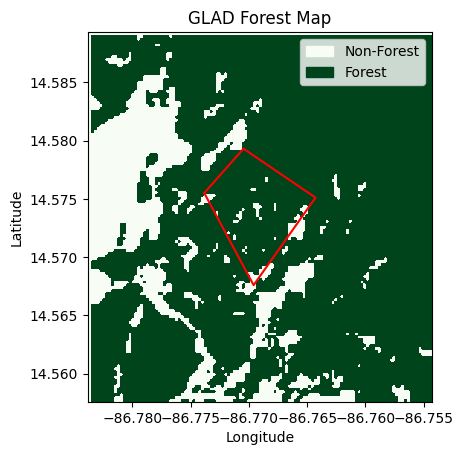

In [13]:
from typing import cast

import matplotlib.pyplot as plt
from shapely.geometry import box

from vibe_core.data import CategoricalRaster, Raster
from vibe_notebook.raster import read_raster

# Define your geometry
bounding_box = box(*geom.buffer(0.01).bounds)

# Get the bounds of the geometry
minx, miny, maxx, maxy = bounding_box.bounds

merged_raster = cast(Raster, run.output["merged_product"][0])
categories = cast(CategoricalRaster, run.output["categorical_raster"][0]).categories

out_image = read_raster(merged_raster, bounding_box)[0]

cmap = plt.get_cmap("Greens", len(categories))

# Plot the cropped image with latitude and longitude in the axes
plt.imshow(out_image[0], cmap=cmap, extent=[minx, maxx, miny, maxy])

# Add a legend
legend = plt.legend(
    handles=[
        plt.Rectangle((0, 0), 1, 1, color=cmap(0)),
        plt.Rectangle((0, 0), 1, 1, color=cmap(1)),
    ],
    labels=categories,
)

# Plot geom on top of the cropped image
plt.plot(*geom.exterior.xy, color="red")

plt.title("GLAD Forest Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")


plt.show()